# Libraries

All the libraries and functions needed to execute the code in the notebok are imported.

In [ ]:
# General
import tarfile
import re
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Processing
import nltk
nltk.download('punkt_tab')

import warnings
warnings.filterwarnings('ignore')

# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Mounted at /content/drive


In [ ]:
# Set the base path if needed
base_path = '/content/drive/My Drive'

# Importing The Data

The data for the CNN and Daily Mail news articles is loaded.

In [ ]:
with tarfile.open(f'{base_path}/Text_Mining_Project_881765_933735/Data/cnn_stories.tgz', mode='r:*') as tgz:
  cnn_stories_full = [tgz.extractfile(story).read().decode("utf-8") for story in tgz.getmembers()[1:]]

In [ ]:
with tarfile.open(f'{base_path}/Text_Mining_Project_881765_933735/Data/dailymail_stories.tgz', mode='r:*') as tgz:
  dailymail_stories_full = [tgz.extractfile(story).read().decode("utf-8") for story in tgz.getmembers()[1:]]

The first 25000 documents from each of the two datasets are taken

In [ ]:
cnn_stories = cnn_stories_full[:25000]
dailymail_stories = dailymail_stories_full[:25000]

In [ ]:
print(f'Number of documents: {len(cnn_stories_full) + len(dailymail_stories_full)}')

Number of documents: 312085


In [ ]:
print(f'Number of documents: {len(cnn_stories) + len(dailymail_stories)}')

Number of documents: 50000


# Cleaning

## CNN

To clean the CNN news articles data the following operations are done:


*   The stories that don't have a summary are removed:

In [ ]:
cnn_stories = [story for story in cnn_stories if story[:story.find('\n\n@highlight')]]

*   In some articles a header might be present, this is removed:

In [ ]:
cnn_stories = [re.sub(r'^.*?-- ', '', story.split('\n\n',1)[0], flags=re.DOTALL)
               + '\n\n'
               + story.split('\n\n',1)[1] for story in cnn_stories]

*   In some articles a footer might be present, this is removed:

In [ ]:
pattern = re.escape('E-mail to a friend') + ".*?" + re.escape('\n\n@highlight')
cnn_stories = [re.sub(pattern, '\n\n@highlight', story, flags=re.DOTALL) for story in cnn_stories]

## Daily Mail

To clean the CNN news articles data the following operations are done:


*   Different styles of headers are present, these are all removed:

In [ ]:
patterns_1 = [(re.compile(r'UPDATED.*?(?:\n+.*?){2}\n+(.*)', re.DOTALL), "UPDATED"),
              (re.compile(r'PUBLISHED.*?(?:\n+.*?){2}\n+(.*)', re.DOTALL), "PUBLISHED"),
              (re.compile(r'CREATED.*?(?:\n+.*?){2}\n+(.*)', re.DOTALL), "CREATED"),
              (re.compile(r'Last updated.*?\n+(.*)', re.DOTALL), "Last updated at")]

patterns_2 = (re.compile(r"Created \d+:"), re.compile(r'Created.*?\n+(.*)', re.DOTALL))

patterns_3 = ("By\n", "By \n")

In [ ]:
def header_remover(doc):

  for pattern, flag in patterns_1:
    if flag in doc: doc = pattern.search(doc).group(1)

  if patterns_2[0].search(doc): doc = patterns_2[1].search(doc).group(1)

  for flag in patterns_3:
    if doc.startswith(flag): doc = doc[doc.find('\n\n'):][2:]

  return doc

In [ ]:
dailymail_stories = [header_remover(doc) for doc in dailymail_stories]

## Further Operations

Now the two sets of data can be merged, and some further cleaning operations are done:


In [ ]:
stories = cnn_stories + dailymail_stories

*   The nobreaking space character "\xa0" is removed:

In [ ]:
stories = [re.sub('\xa0', '', story) for story in stories]

*   There are some full stops missing in the articles, these are instances of \n\n that are not preceded by punctuation mark. They are put in (this will help with sentence tokenization):

In [ ]:
stories = [re.sub(r'(?<=[A-Za-z0-9])\n\n', '.\n\n', story.split('\n\n@highlight',1)[0])
           + '\n\n@highlight'
           + story.split('\n\n@highlight',1)[1] for story in stories]

*   Web links, in all of their possible formats, are removed:

In [ ]:
patterns = [(re.compile(r"http\S+"), ""),
            (re.compile(r"www\.[A-Za-z]*\.com"), ""),
            (re.compile(r"[A-Za-z]*\.com"), "")
            ]

def link_remover(story):
  for pattern, replacement in patterns:
    story = pattern.sub(replacement, story)
  return story

stories = [link_remover(story) for story in stories]

The articles are now shuffled, setting a seed for reproducibility.

In [ ]:
random.Random(15).shuffle(stories)

The proper articles (the documents) and their summaries are extracted, into `docs` and `summary_labels` respectively.

In [ ]:
docs = [story[:story.find('\n\n@highlight')] for story in stories]
summary_labels = [re.sub(r"\n\n@highlight\n\n(NEW: )?", "\n", story[story.find("\n\n@highlight\n\n"):])[1:] for story in stories]

In [ ]:
stories_full = cnn_stories_full + dailymail_stories_full
docs_full = [story[:story.find('\n\n@highlight')] for story in stories_full]
summary_labels_full = [re.sub(r"\n\n@highlight\n\n(NEW: )?", "\n", story[story.find("\n\n@highlight\n\n"):])[1:] for story in stories_full]

An exaple of document and an example of summary can be printed, to make more understandable they current format:

In [ ]:
print(docs[0])

British authorities said Tuesday they are conducting a criminal investigation into an American man charged in federal court with smuggling weapons into England.

Steven Neal Greenoe is suspected of buying more than 60 firearms in North Carolina and transporting them to England on at least nine occasions, according to court documents.

In September, a federal grand jury handed up a 43-count superseding indictment against him. He was arrested in July, when authorities found another 16 firearms in his baggage.

TITAN, a task force in Britain's North West region for serious and organized crimes, said in a statement Tuesday it was also investigating Greenoe.

"This is a complex investigation involving law enforcement agencies across the North West of England," Detective Chief Superintendent Simon Leach, who heads the task force, said in the statement. "We are working closely with our colleagues nationally and with partners in the United States. The availability of firearms poses a serious r

In [ ]:
print(summary_labels[0])

Steven Greenoe is charged in a 43-count indictment
Authorities allege he illegally brought at least 60 guns into Britain
British authorities say they are also conducting a criminal investigation


# Exploration

To find other issues that might still be present the distribution of the data is explored.

Two lists containing the length of each document and each summary are created.

In [ ]:
doc_count = [len(nltk.sent_tokenize(doc)) for doc in docs]

summary_count = [len(summary.split('\n')) for summary in summary_labels]

First, the distribution of the number of sentences present in each document is plotted with an histogram; the min value, 1st quartile, mean, 3rd quartile and max value are also shown with dashed lines.

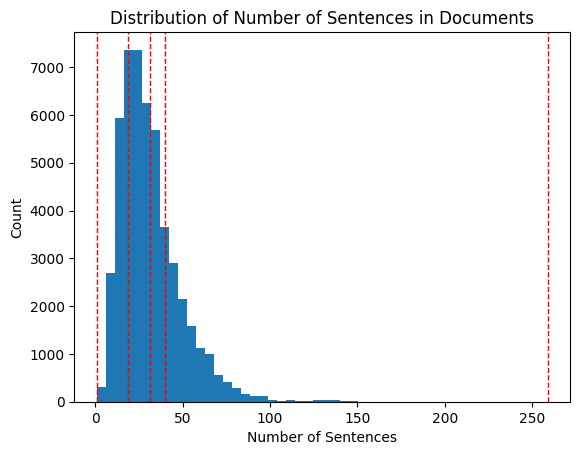

In [ ]:
plt.hist(doc_count, bins=50)
plt.axvline(x=np.mean(doc_count), color="red", linestyle="--", linewidth=1)
for q in [0, 0.25, 0.75, 1]: plt.axvline(x=np.quantile(doc_count, q), color="red", linestyle="--", linewidth=1)
plt.xlabel('Number of Sentences'), plt.ylabel('Count')
plt.title('Distribution of Number of Sentences in Documents')

plt.show()

The distribution is extremely skewed, an example of one of these extreme cases that cause this can be printed:

In [ ]:
docs[np.argmax(doc_count)]

"1. Where, allegedly, was Moldovan dancer Dominca Cemortan to be found on the evening of January 13?\n\nA. Giving 'political advice' to Silvio Berlusconi.\n\nB. Hiding in One Direction heartthrob Harry Styles' wardrobe.\n\nC. In A&E after a nasty tango accident on the Strictly tour.\n\nD. On the bridge of Italian cruise ship Costa Concordia.\n\n2. Gangnam Style! But what is Gangnam?'\n\nA. I am proud to say I do not know.\n\nB. It's Korean for 'make an idiot of yourself pretending to ride a horse'.\n\nC. A posh district of Seoul.\n\nD. A type of slicked-back haircut.\n\n3. Which officials did Bruce Springsteen annoy in Hyde Park in July?\n\nA. The deckchair attendants, when he and his drummer ‘forgot' to pay.\n\nB. Traffic wardens, when his tour-bus double-parked.\n\nC. Westminster Council, who cut him off for over-running.\n\nD. The official hot-dog stall, which he described as 'born to give you the runs'.\n\n4. What famous disaster sank in the ratings in April?\n\nA. How To Look Good

Since these extreme documents are just few and the example showed that they also might not be of any value the documents with more than 145 sentences, and their relative summaries, are dropped.

In [ ]:
for x in reversed(range(len(docs))):
  if doc_count[x] > 145:
    docs.pop(x)
    summary_labels.pop(x)
    summary_count.pop(x)
    doc_count.pop(x)

The same operation is done for the number of sentences in each of the summaries, starting with the histogram.

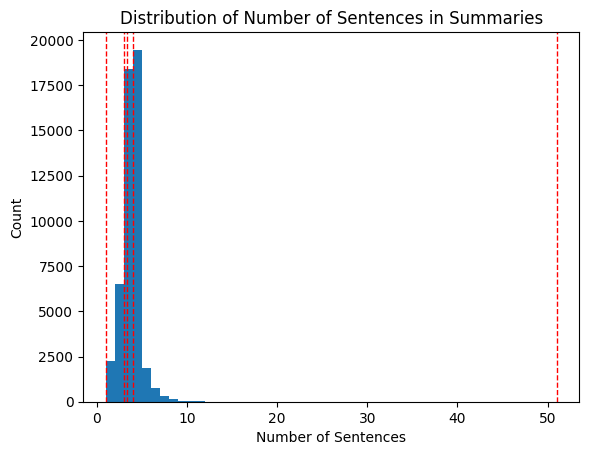

In [ ]:
plt.hist(summary_count, bins=50)
plt.axvline(x=np.mean(summary_count), color="red", linestyle="--", linewidth=1)
for q in [0, 0.25, 0.75, 1]: plt.axvline(x=np.quantile(summary_count, q), color="red", linestyle="--", linewidth=1)
plt.xlabel('Number of Sentences'), plt.ylabel('Count')
plt.title('Distribution of Number of Sentences in Summaries')

plt.show()

Also in this case the distribution is extremely skewed and a couple of the extreme cases are printed:

In [ ]:
summary_labels[np.argmax(summary_count)]

'The Great British Bake Off final expects to draw an audience of over 4 million tonight\n27% of Britons say they will bake more in the next year\nNational Baking Week runs 15th -21st October\nBaking is most popular in Yorkshire\n1 in 7 adults bake at least twice a week\nServants leave for the First World War and work in other careers. Women work in armament factories and in other jobs, giving them less time to bake\nThe Women’s Institute is founded in 1915. Advice on cookery is offered and members share their experiences at meetings. After the war their magazine Home and Country, offers recipes and advice\nThe National Confectionary Industry started to issue adverts in press, encouraging women to take up home baking as a source of extra income\nGood Housekeeping Magazine is first published in 1922\nReady shredded packets of beef suet are advertised with the strapline of “What visions of delight...”. The advert refers to Spotted Dick amongst others recipes - this is for women who contin

Also in this case the extreme cases are just few and the example showed that they are not of of any value. The summaries with more than 15 sentences, and their relative documents, are dropped.

In [ ]:
for x in reversed(range(len(summary_labels))):
  if summary_count[x] > 15:
    docs.pop(x)
    summary_labels.pop(x)
    summary_count.pop(x)
    doc_count.pop(x)

The newline escape characters used to separate sentences in the summaries are no loner useful and so they are removed.

In [ ]:
summary_labels = [re.sub('\n', ' ', summary) for summary in summary_labels]

## Subset Evaluation

To verify that the distribution of the selected subset is consistent with that of the original dataset, the same exploratory data analysis plots are generated for the original dataset. The first step is therefore to create lists containing the lengths of each document and each corresponding summary.

In [ ]:
doc_count_full = [len(nltk.sent_tokenize(doc)) for doc in docs_full]
summary_count_full = [len(summary.split('\n')) for summary in summary_labels_full]

The histogram representing the distribution of sentences per document is displayed.

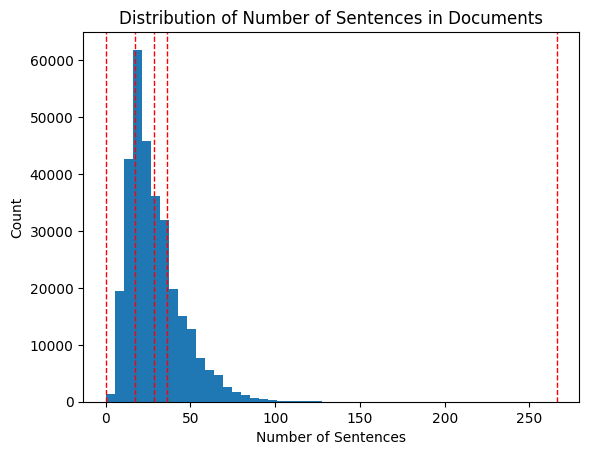

In [ ]:
plt.hist(doc_count_full, bins=50)
plt.axvline(x=np.mean(doc_count_full), color="red", linestyle="--", linewidth=1)
for q in [0, 0.25, 0.75, 1]: plt.axvline(x=np.quantile(doc_count_full, q), color="red", linestyle="--", linewidth=1)
plt.xlabel('Number of Sentences'), plt.ylabel('Count')
plt.title('Distribution of Number of Sentences in Documents')

plt.show()

Then, the histogram showing the distribution of sentences per summary is presented.

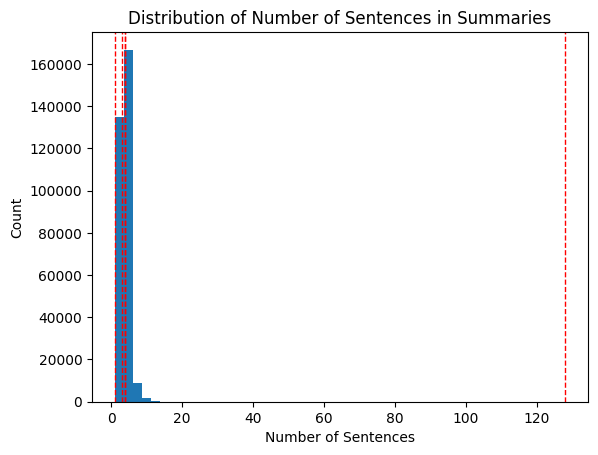

In [ ]:
plt.hist(summary_count_full, bins=50)
plt.axvline(x=np.mean(summary_count_full), color="red", linestyle="--", linewidth=1)
for q in [0, 0.25, 0.75, 1]: plt.axvline(x=np.quantile(summary_count_full, q), color="red", linestyle="--", linewidth=1)
plt.xlabel('Number of Sentences'), plt.ylabel('Count')
plt.title('Distribution of Number of Sentences in Summaries')

plt.show()

Both histograms closely resemble those of the subset, indicating that the distributions of the two datasets are similar.

## Final check

The number of articles left, the total and average number of sentences per document and the total and average number of sentences per summary are respectively:

In [ ]:
print(f'Number of documents/summaries: {len(docs)}')

Number of documents/summaries: 49887


In [ ]:
print(f'Total number of sentences in the documents: {sum(doc_count)}\naverage number of sentences per document: {np.mean(doc_count)}')

Total number of sentences in the documents: 1565885
average number of sentences per document: 31.388638322609097


In [ ]:
print(f'Total number of sentences in the summaries: {sum(summary_count)}\naverage number of sentences per summary: {np.mean(summary_count)}')

Total number of sentences in the summaries: 166940
average number of sentences per summary: 3.3463627798825346


# Exporting The Data

The cleaned data for both documents and summaries is saved in the "Data" folder as pickle files.

In [ ]:
with open(f'{base_path}/Text_Mining_Project_881765_933735/Data/docs', "wb") as fp:
  pickle.dump(docs, fp)

In [ ]:
with open(f'{base_path}/Text_Mining_Project_881765_933735/Data/summary_labels', "wb") as fp:
  pickle.dump(summary_labels, fp)